In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
'''
Sunday, 07/13/2025

I finished coding for task based learning arm reach, Eric wants me to try decoder swap for arm reach before we move to muscle models 
'''

'\nSunday, 07/13/2025\n\nI finished coding for task based learning arm reach, Eric wants me to try decoder swap for arm reach before we move to muscle models \n'

In [3]:
import os
os.chdir('/root/vast/joshua/')
print(os.getcwd())

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

/root/vast/joshua


In [ ]:
import pandas as pd
import jax
from jax.experimental import checkify
import jax.numpy as jp
import mujoco
# import wandb
# from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from IPython.display import clear_output, display
from IPython.display import Video

from matplotlib.animation import FFMpegWriter
from orbax import checkpoint as ocp
from tqdm import tqdm
import h5py

from vnl_mjx.tasks.mouse import mouse_reach_josh



jax.config.update("jax_debug_nans", True)

# # Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)


import jax.numpy as jp
import numpy as np
from track_mjx.agent import checkpointing
from track_mjx.agent.mlp_ppo.intention_network import Decoder, Encoder
from track_mjx.analysis.rollout import create_environment
from track_mjx.analysis.render import render_from_saved_rollout, display_video
from track_mjx.analysis.utils import save_to_h5py, load_from_h5py
from dm_control import mjcf as mjcf_dm
import mujoco
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import multiprocessing as mp
import functools
from track_mjx.io import load

# from track_mjx.agent.mlp_ppo.intention_network import make_intention_policy
from track_mjx.agent.mlp_ppo.ppo_networks import make_intention_ppo_networks
from track_mjx.agent.mlp_ppo.intention_network import make_intention_policy
from track_mjx.agent.mlp_ppo import ppo_networks
from brax.training.acme import running_statistics
import h5py
import numpy as np
from tqdm import tqdm

from track_mjx.agent import checkpointing
from orbax import checkpoint as ocp
import yaml
import jax
from omegaconf import OmegaConf
from brax.training import distribution

jax.clear_caches()

# First get the imitation learning rollouts from checkpoint

In [8]:
from josh_helper.ckpt_renderer import JoshCKPT_ModelImitationLearning

In [26]:
jjp = JoshCKPT_ModelImitationLearning()
jjp.cry()
jjp.eval_checkpoint()

Using data file: /root/vast/eric/stac-mjx/reaches_A36-1_2023-07-18_16-54-01_lightOff_tone_on_reach2_ik.h5
Found checkpoint at step 3436

Successfully loaded policy parameters
Using first file path: /root/vast/eric/stac-mjx/reaches_A36-1_2023-07-18_16-54-01_lightOff_tone_on_reach2_ik.h5
Loaded reference clip with 107 frames
Joint names: ['sh_elv', 'sh_extension', 'sh_rotation', 'elbow_joint']
env._steps_for_cur_frame: 1
env._steps_for_cur_frame: 5.0
Actual observation shape: (163,)
Reference observation size: 155
Action size: 4
Using clip index: 0
Reference clip shape: (107, 4)


In [ ]:
frames = render_from_saved_rollout(
        rollout=jjp.rollout_dict, 
        walker_type="mouse-arm",  
        max_frames=210,
    )
vid, anime = display_video(frames, framerate=20)
vid

MuJoCo Rendering...


100%|██████████| 210/210 [00:43<00:00,  4.83it/s]


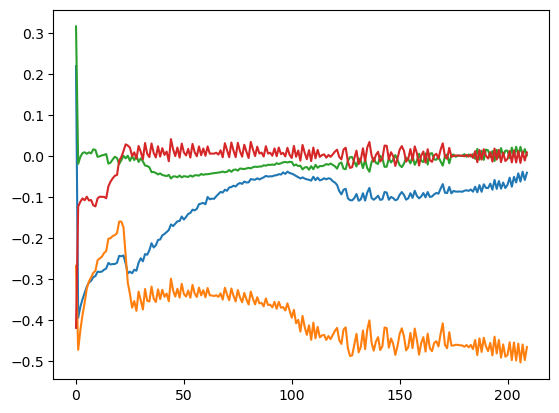

In [27]:
plt.plot(jjp.rollout_dict['action'][:, 0])
plt.plot(jjp.rollout_dict['action'][:, 1])
plt.plot(jjp.rollout_dict['action'][:, 2])
plt.plot(jjp.rollout_dict['action'][:, 3])

# Okay, imitation seems.. runnable. Time for decoder freezing

In [6]:
import os
os.chdir('/root/vast/joshua/')
import numpy as np
from josh_helper.ckpt_renderer import JoshCKPT_Model, h5Cooker
import jax.numpy as jp

In [7]:
targets = np.array([
        [0.004, 0.012, -0.006],
        [0.0025355, 0.012, -0.0024645],
        [-0.001, 0.012, -0.001],
        [-0.0045355, 0.012, -0.0024645],
        [-0.006, 0.012, -0.006],
        [-0.0045355, 0.012, -0.0095355],
        [-0.001, 0.012, -0.011],
        [0.0025355, 0.012, -0.0095355],
    ])

In [ ]:
jjp = JoshCKPT_Model(
 ckpt_path='/root/vast/joshua/vnl-playground/model_checkpoints/250716_185126'
)
jjp.eval_checkpoint(
    targets[3:5],
    render_8_targets=True,
    save_data=True,
    iters_per_target=2,
    data_filename='/root/vast/joshua/vnl-playground/data/temp.h5'
    )
jjp.display_video()

Found checkpoint at step 18
------------------------------------------------------------------
Env reset with target position [-0.001  0.012 -0.011]


In [ ]:
h = h5Cooker('/root/vast/joshua/vnl-playground/data/predefined_targets_decoder_swap.h5')
h.get_keys()

['actions_rollout_0',
 'actions_rollout_1',
 'actions_rollout_2',
 'actions_rollout_3',
 'actions_rollout_4',
 'actions_rollout_5',
 'actions_rollout_6',
 'actions_rollout_7',
 'decoders_0',
 'decoders_1',
 'decoders_2',
 'decoders_3',
 'decoders_4',
 'decoders_5',
 'decoders_6',
 'decoders_7',
 'encoders_0',
 'encoders_1',
 'encoders_2',
 'encoders_3',
 'encoders_4',
 'encoders_5',
 'encoders_6',
 'encoders_7',
 'frames_0',
 'frames_1',
 'frames_2',
 'frames_3',
 'frames_4',
 'frames_5',
 'frames_6',
 'frames_7',
 'handp_rollout_0',
 'handp_rollout_1',
 'handp_rollout_2',
 'handp_rollout_3',
 'handp_rollout_4',
 'handp_rollout_5',
 'handp_rollout_6',
 'handp_rollout_7',
 'handv_rollout_0',
 'handv_rollout_1',
 'handv_rollout_2',
 'handv_rollout_3',
 'handv_rollout_4',
 'handv_rollout_5',
 'handv_rollout_6',
 'handv_rollout_7',
 'intentions_0',
 'intentions_1',
 'intentions_2',
 'intentions_3',
 'intentions_4',
 'intentions_5',
 'intentions_6',
 'intentions_7',
 'jointv_rollout_0',
 'j

### Trained decoder swap on a separate python file

In [23]:
# jjp = JoshCKPT_Model(
#  ckpt_path='/root/vast/joshua/vnl-playground/model_checkpoints/250716_185126'
# )

datapath = '/root/vast/joshua/vnl-playground/data/predefined_targets_decoder_swap.h5'
foldername = '/root/vast/joshua/vnl-playground/data/meeting_july_17'


with h5py.File(datapath, 'r') as F:
    for n in range(8):
        filename = f'{foldername}/predefined_targets_decoder_swap_{n}.mp4'
        data = F[f'frames_{n}'][:]
        jjp.display_video(
            data=np.vstack(data),
            save_video=True,
            filename=filename,
        )

Displaying Video
Saving video to /root/vast/joshua/vnl-playground/data/meeting_july_17/predefined_targets_decoder_swap_0.mp4
Displaying Video
Saving video to /root/vast/joshua/vnl-playground/data/meeting_july_17/predefined_targets_decoder_swap_1.mp4
Displaying Video
Saving video to /root/vast/joshua/vnl-playground/data/meeting_july_17/predefined_targets_decoder_swap_2.mp4
Displaying Video
Saving video to /root/vast/joshua/vnl-playground/data/meeting_july_17/predefined_targets_decoder_swap_3.mp4
Displaying Video
Saving video to /root/vast/joshua/vnl-playground/data/meeting_july_17/predefined_targets_decoder_swap_4.mp4
Displaying Video
Saving video to /root/vast/joshua/vnl-playground/data/meeting_july_17/predefined_targets_decoder_swap_5.mp4
Displaying Video
Saving video to /root/vast/joshua/vnl-playground/data/meeting_july_17/predefined_targets_decoder_swap_6.mp4
Displaying Video
Saving video to /root/vast/joshua/vnl-playground/data/meeting_july_17/predefined_targets_decoder_swap_7.mp4


### Getting velocity curves

In [ ]:
cook = h5Cooker(filepath=datapath)
hand_v = cook.get_data('handv_rollout')
hand_v = np.linalg.norm(hand_v, axis=2)

hand_v.shape

(80, 100)

Text(0.5, 0, 'Time elapsed (ms)')

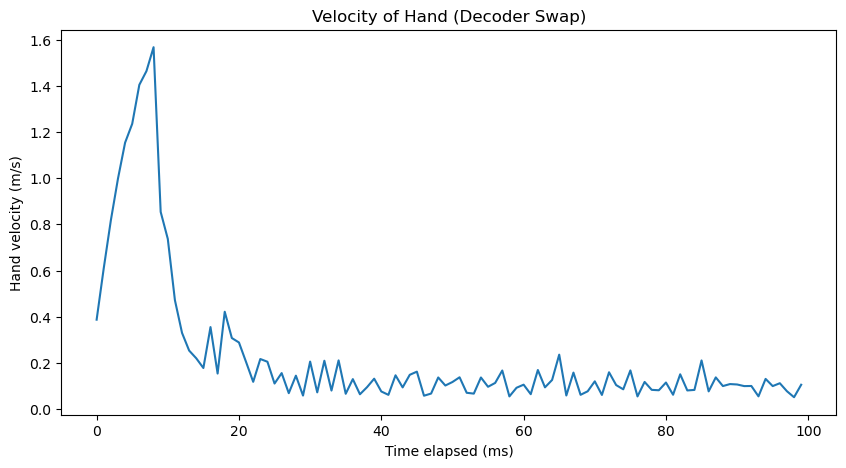

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(hand_v[:1,:].reshape(-1))
plt.title('Velocity of Hand (Decoder Swap)')
plt.ylabel('Hand velocity (m/s)')
plt.xlabel('Time elapsed (ms)')
# plt.savefig(f'josh_helper/hand_vel_plot.png')


/tmp/ipykernel_134600/3021820583.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


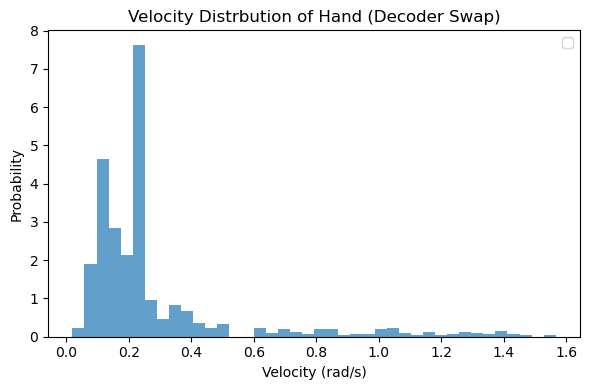

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(hand_v.reshape(-1), bins=40, density=True, alpha=0.7)
ax.set_xlabel("Velocity (rad/s)")
ax.set_ylabel("Probability")
ax.set_title(f"Velocity Distrbution of Hand (Decoder Swap)")
ax.legend()

plt.tight_layout()
# plt.savefig(f'josh_helper/{names[n]}.png')
plt.show()

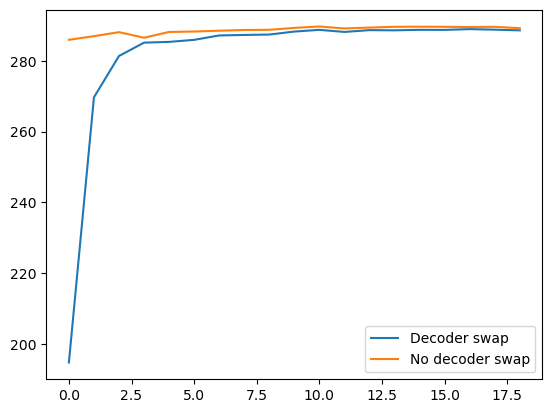

In [ ]:
decoder_csv = '/root/vast/joshua/vnl-playground/data/meeting_july_17/decoder_swap_eval.csv'
nodecoder_csv = '/root/vast/joshua/vnl-playground/data/meeting_july_17/nodecoder_swap_eval.csv'

data1 = pd.read_csv(decoder_csv)
data2 = pd.read_csv(nodecoder_csv)
plt.plot(data1['mouse_arm-reach_t_lower_lr_250716_185126 - eval/episode_reward'], label='Decoder swap')
plt.plot(data2['mouse_arm-reach_t_lower_lr_250709_191739 - eval/episode_reward'], label='No decoder swap')
plt.title('Training Curves for Decoder swap and No Decoder Swap')
plt.ylabel('Reward')
plt.xlabel('Eval Step')
plt.legend()

In [16]:
data1.head()

,Step,mouse_arm-reach_t_lower_lr_250716_185126 - eval/episode_reward,mouse_arm-reach_t_lower_lr_250716_185126 - eval/episode_reward__MIN,mouse_arm-reach_t_lower_lr_250716_185126 - eval/episode_reward__MAX
0,0,194.846375,194.846375,194.846375
1,1,269.665466,269.665466,269.665466
2,2,281.337738,281.337738,281.337738
3,3,285.100830,285.100830,285.100830
4,4,285.314270,285.314270,285.314270


## Some code to figure out config stuff for decoder swap

In [60]:
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

cfg = initialize(config_path="../vnl_mjx/config", job_name='sad')
cfg = compose(config_name="arm_reach")


/tmp/ipykernel_74328/1161757271.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  cfg = initialize(config_path="../vnl_mjx/config", job_name='sad')


In [15]:
from track_mjx.agent.checkpointing import load_policy
import pprint

In [ ]:
loaded_checkpoint = load_policy(
    checkpoint_path='/root/vast/eric/checkpoints-track-mjx/model_checkpoints/mouse_arm/reaches_A36-5_2023-07-18_15-59-17_lightOff_tone_on_reach5_ik_250324_070449'
)
policy = loaded_checkpoint[1]

In [14]:
loaded_checkpoint[1].keys()

dict_keys(['params'])

In [38]:
# policy['params']['decoder'].keys()
# policy['params']['decoder']['LayerNorm_0']['scale'].shape
# policy['params']['decoder']['hidden_0']['kernel'].shape
policy['params']['encoder']['hidden_0']['kernel'].shape

(155, 512)

In [67]:
c='/root/vast/eric/checkpoints-track-mjx/model_checkpoints/mouse_arm/reaches_A36-5_2023-07-18_15-59-17_lightOff_tone_on_reach5_ik_250324_070449'
config_dict=OmegaConf.to_container(cfg, resolve=True)
cfg = load_policy(c, cfg=config_dict, freeze_decoder=True)

In [64]:
cfg['network_config']

{'arch_name': 'intention', 'encoder_layer_sizes': [512, 512, 512], 'decoder_layer_sizes': [512, 512, 512], 'critic_layer_sizes': [512, 512, 512], 'intention_size': 3, 'kl_schedule': False, 'kl_weight': 0, 'normalize_observations': True, 'action_size': 4, 'imitation_observation_size': 163, 'imitation_reference_obs_size': 155, 'task_observation_size': 23, 'task_reference_obs_size': 15}